In [1]:
import requests
from bs4 import BeautifulSoup
import urllib
from urllib.parse import urljoin, urlparse,urlencode
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
# load default skills data base
from skillNer.general_params import SKILL_DB
# import skill extractor
from skillNer.skill_extractor_class import SkillExtractor
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
# init params of skill extractor
nlp = spacy.load("en_core_web_lg")

In [32]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from pylab import rcParams
rcParams['figure.figsize'] = 50, 20
import nltk
from nltk.corpus import stopwords
import re
import time
start=time.time()
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RAHAT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pip show spacy

Name: spacy
Version: 3.4.4
Summary: Industrial-strength Natural Language Processing (NLP) in Python
Home-page: https://spacy.io
Author: Explosion
Author-email: contact@explosion.ai
License: MIT
Location: c:\users\rahat\appdata\roaming\python\python37\site-packages
Requires: catalogue, cymem, jinja2, langcodes, murmurhash, numpy, packaging, pathy, preshed, pydantic, requests, setuptools, smart-open, spacy-legacy, spacy-loggers, srsly, thinc, tqdm, typer, typing-extensions, wasabi
Required-by: en-core-web-lg, en-core-web-sm, pyresparser, resume-parser, skillNer
Note: you may need to restart the kernel to use updated packages.


In [3]:
def get_full_match(annotations):
    skills=set()
    full_match=annotations['results']['full_matches']
    for dict_item in full_match:
        skills.add(dict_item['doc_node_value'])
    return skills

def get_sub_matches(annotations):
    skills=set()
    sub_match=annotations['results']['ngram_scored']
    for dict_item in sub_match:
        if dict_item['score'] >=0.7:
            skills.add(dict_item['doc_node_value'])  
    return skills

def extract_skills(des):
    skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)
    annotations = skill_extractor.annotate(des)
    full_match=get_full_match(annotations)
    print("Full Match:",len(full_match))
    sub_match=get_sub_matches(annotations)
    print("Sub Match:",len(sub_match))
    full_match=full_match.union(sub_match)
    return full_match

In [9]:
def get_job_links_from_carrierbuilder(params):
      base_url="https://www.careerbuilder.com"
      headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,'
                  'application/signed-exchange;v=b3;q=0.9',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.9',
        'cache-control': 'max-age=0',
        'sec-fetch-dest': 'document',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'none',
        'sec-fetch-user': '?1',
        'upgrade-insecure-requests': '1',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'}
      url=base_url+"/jobs?"
      links = []
      for i in range(0, 3):
            extention = ""
            if i != 0:
                  params['page_number']=params['page_number']+1
            url_to_scrape = url + urllib.parse.urlencode(params)
            print(url_to_scrape)
            r = requests.get(url_to_scrape,headers=headers)
            soup = BeautifulSoup(r.content, 'html.parser')
            joblisting = soup.select('.data-results-content-parent')
            print(len(joblisting))
            for job in joblisting:
                if job.select('a.data-results-content'):
                    job_link = job.select_one('a.data-results-content')['href']
                    complete_link = base_url + job_link
                    links.append(complete_link)
      return links

In [5]:
def parse_job_carrier_builder(url):
      headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,'
                  'application/signed-exchange;v=b3;q=0.9',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.9',
        'cache-control': 'max-age=0',
        'sec-fetch-dest': 'document',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'none',
        'sec-fetch-user': '?1',
        'upgrade-insecure-requests': '1',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
      }
      r = requests.get(url,headers = headers)
      soup = BeautifulSoup(r.content, 'html.parser')
      try:
        title = soup.select_one('.jdp_title_header').getText().strip()
      except:
        title='None'
      try:
        desc = soup.select_one('.jdp-description-details>.col-2>.jdp-left-content').getText().strip()
      except:
        desc="None" 
      try:
        company = soup.select_one('.data-details').getText().strip()
      except:
        company="None"
      jobs = {
        'position': title,
        'company': company,
        'description': desc,
        'link' : url,
        }
      return jobs

In [6]:
def get_full_match(annotations):
    skills=set()
    full_match=annotations['results']['full_matches']
    for dict_item in full_match:
        skills.add(dict_item['doc_node_value'])
    return skills

def get_sub_matches(annotations):
    skills=set()
    sub_match=annotations['results']['ngram_scored']
    for dict_item in sub_match:
        if dict_item['score'] >=0.6:
            skills.add(dict_item['doc_node_value'])  
    return skills

def extract_skills(des):
    try:
        annotations = skill_extractor.annotate(des)
        full_match=get_full_match(annotations)
        print("Full Match:",len(full_match))
        sub_match=get_sub_matches(annotations)
        print("Sub Match:",len(sub_match))
        full_match=full_match.union(sub_match)
        return ','.join(str(x) for x in full_match)
    except:
        return " "


In [7]:
def tokenizer(df):
    
    
    '''
        Parse the given skills dataframe to pull out appropriate skill phrases.
        Dataframe has some cells that are 2-gram nicely made skills, and other cells
        that are long runons with many skills.
        After scrubbing and then splitting on commas, we simplify the task by tossing
        out any greater than 4-gram phrases. 
    '''
    
    # Custom stop words that come up very often but don't say much about the job title.
    stops = ['manager', 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily',
             'services', 'job', 'using', '.com', 'end', 'prepare', 'prepared', 'lead', 'requirements','#39'] + list(stopwords.words('english'))
    values, ids, resume_ids = [],[],[]
    count = 0
    for idx, row in df.iterrows():
        # Split on commas
        array = row['skill'].lower().split(',')
        for x in array:
            # make sure the value is not empty or all numeric values or in the stop words list
            if x != '' and not x.lstrip().rstrip() in stops and not x.lstrip().rstrip().isdigit():
                # make sure single character results are the letter 'C' (programming language)
                if len(x) > 1 or x == 'C':
                    # drop stuff > 4 gram
                    if len(x.split(' ')) <= 4:
                        # update lists
                        
                        values.append(x.lstrip().rstrip())
                        ids.append(count)
                        count+=1
    
    # New dataframe with updated values.
    result_df = pd.DataFrame()
    
    result_df['skill'] = values
    return result_df

In [8]:
def text_scrubber(values):
    
    '''
        Replace problematic phrases and unicode characters.
        
        (10+ years) ---> ''
        &#39; , \x92 ---> apostrophe
        Technical: ---> ''
        
        These characters act usually as separators, so replace them with commas for splitting later.
            [:, ;, &amp;, \x95, &, ., /, 'and'] ---> ','
        
    '''
    result = []
    for string in values:
        # Regex as explained above
        temp = re.sub('(\(.*\))', '', string)
        temp = re.sub('&#39;|\x92', '\'', temp)
        temp = re.sub(' &amp; |&amp;|\x95|:|;|&|\.|/| and ', ',', temp)
        temp = re.sub('\w*:\s+', ', ', temp)
        
        result.append(temp)
        
    return result


In [10]:
params={
    'keywords':'Web Developer',
    'page_number':1
}
job_links=get_job_links_from_carrierbuilder(params)

https://www.careerbuilder.com/jobs?keywords=Web+Developer&page_number=1
25
https://www.careerbuilder.com/jobs?keywords=Web+Developer&page_number=2
25
https://www.careerbuilder.com/jobs?keywords=Web+Developer&page_number=3
25


In [11]:
job_details=[]
for link in job_links:
    job_details.append(parse_job_carrier_builder(link))

In [12]:
df=pd.DataFrame(job_details)

In [13]:
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)
df['skill']=df['description'].apply(extract_skills)

loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...


C:\Users\RAHAT\AppData\Roaming\Python\Python37\site-packages\skillNer\utils.py:99: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  vec_similarity = token1.similarity(token2)


Full Match: 39
Sub Match: 84
Full Match: 21
Sub Match: 27
Full Match: 30
Sub Match: 71
Full Match: 30
Sub Match: 71
Full Match: 27
Sub Match: 60
Full Match: 31
Sub Match: 71
Full Match: 9
Sub Match: 17
Full Match: 9
Sub Match: 17
Full Match: 9
Sub Match: 19
Full Match: 14
Sub Match: 27
Full Match: 18
Sub Match: 72
Full Match: 9
Sub Match: 11
Full Match: 21
Sub Match: 70
Full Match: 23
Sub Match: 54
Full Match: 20
Sub Match: 43
Full Match: 17
Sub Match: 36
Full Match: 27
Sub Match: 42
Full Match: 12
Sub Match: 35
Full Match: 10
Sub Match: 26
Full Match: 13
Sub Match: 19
Full Match: 26
Sub Match: 59
Full Match: 6
Sub Match: 11
Full Match: 22
Sub Match: 46
Full Match: 29
Sub Match: 56
Full Match: 15
Sub Match: 27
Full Match: 14
Sub Match: 20
Full Match: 16
Sub Match: 35
Full Match: 19
Sub Match: 27
Full Match: 10
Sub Match: 45
Full Match: 16
Sub Match: 45
Full Match: 12
Sub Match: 51
Full Match: 22
Sub Match: 56
Full Match: 13
Sub Match: 28
Full Match: 23
Sub Match: 52
Full Match: 22
Sub 

In [14]:
df

,position,company,description,link,skill
0,Senior Web Developer,"The Sherwin-Williams Company\nCleveland, OH (O...","Here, we believe there's not one path to succe...",https://www.careerbuilder.com/job/J3R2GF67GCV3...,"teams cross functional,natural language,techno..."
1,Front End Web Developer,"Sterling Engineering, Inc.\nChicago, IL (On Si...",Title: Front End Developer Location: Chicago...,https://www.careerbuilder.com/job/JMD87EF72355...,"brand,javascript,problem solve,web application..."
2,Web Developer,"The Sherwin-Williams Company\nCleveland, OH (O...","Here, we believe there's not one path to succe...",https://www.careerbuilder.com/job/J3T45X6H0KFP...,"natural language,technology research,agile sof..."
3,Associate Web Developer,"The Sherwin-Williams Company\nCleveland, OH (O...","Here, we believe there's not one path to succe...",https://www.careerbuilder.com/job/J3N2LG6HT28Q...,"natural language,technology research,agile sof..."
4,Senior React Front End Web Developer,"INSPYR Solutions, LLC\nKaty, TX (On Site)\nFul...",INSPYR is hiring a Senior React Front End Web ...,https://www.careerbuilder.com/job/JMD87010C195...,"react redux,proactively,mechanisms,continuous ..."
...,...,...,...,...,...
70,"Senior Web Developer (JavaScript- React, Vue, ...","Conexess Group\nLas Vegas, NV (Remote)\nFull-Time","Title: Sr. Web Developer (JavaScript- React, V...",https://www.careerbuilder.com/job/J3M2V66WN723...,"research,javascript,web developer,vue,digital,..."
71,"Senior Web Developer (JavaScript- React, Vue, ...","Conexess Group\nIrvine, CA (Remote)\nFull-Time","Title: Sr. Web Developer (JavaScript- React, V...",https://www.careerbuilder.com/job/J3W5HP6DFLN8...,"research,javascript,web developer,vue,digital,..."
72,"Senior Web Developer (JavaScript- React, Vue, ...","Conexess Group\nPhiladelphia, PA (Remote)\nFul...","Title: Sr. Web Developer (JavaScript- React, V...",https://www.careerbuilder.com/job/J3M3XP6V62H7...,"research,javascript,web developer,vue,digital,..."
73,"Senior Web Developer (JavaScript- React, Vue, ...","Conexess Group\nSeattle, WA (Remote)\nFull-Time","Title: Sr. Web Developer (JavaScript- React, V...",https://www.careerbuilder.com/job/J3W66M6GC592...,"research,javascript,web developer,vue,digital,..."


In [15]:
test_df = tokenizer(df)

In [16]:
test_df[:5]

,skill
0,teams cross functional
1,natural language
2,technology research
3,creative thinking
4,agile software development


In [17]:
voc = test_df['skill'].unique()

In [19]:
len(voc)

1128

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [21]:
vec2 = TfidfVectorizer(vocabulary=voc, decode_error='ignore')
skills_matrix2 = vec2.fit_transform(df['skill'])
skills_matrix2 = pd.DataFrame(skills_matrix2.todense())
skills_matrix2.columns = vec2.get_feature_names()

In [22]:
len(skills_matrix2)

75

In [23]:
# Run PCA to reduce number of features
pca = PCA(n_components=len(skills_matrix2), random_state=42)
comps = pca.fit_transform(skills_matrix2)

In [24]:
# Put the components into a dataframe

comps = pd.DataFrame(comps)

In [37]:
# Cluster job titles based on components derived from feature matrix
cltr = AgglomerativeClustering(n_clusters=8)
cltr.fit(comps)

# Add new column containing cluster number to sample, comps, and feature matrix dataframes

df['cluster_no'] = cltr.labels_

In [38]:
df

,position,company,description,link,skill,cluster_no
0,Senior Web Developer,"The Sherwin-Williams Company\nCleveland, OH (O...","Here, we believe there's not one path to succe...",https://www.careerbuilder.com/job/J3R2GF67GCV3...,"teams cross functional,natural language,techno...",1
1,Front End Web Developer,"Sterling Engineering, Inc.\nChicago, IL (On Si...",Title: Front End Developer Location: Chicago...,https://www.careerbuilder.com/job/JMD87EF72355...,"brand,javascript,problem solve,web application...",0
2,Web Developer,"The Sherwin-Williams Company\nCleveland, OH (O...","Here, we believe there's not one path to succe...",https://www.careerbuilder.com/job/J3T45X6H0KFP...,"natural language,technology research,agile sof...",1
3,Associate Web Developer,"The Sherwin-Williams Company\nCleveland, OH (O...","Here, we believe there's not one path to succe...",https://www.careerbuilder.com/job/J3N2LG6HT28Q...,"natural language,technology research,agile sof...",1
4,Senior React Front End Web Developer,"INSPYR Solutions, LLC\nKaty, TX (On Site)\nFul...",INSPYR is hiring a Senior React Front End Web ...,https://www.careerbuilder.com/job/JMD87010C195...,"react redux,proactively,mechanisms,continuous ...",0
...,...,...,...,...,...,...
70,"Senior Web Developer (JavaScript- React, Vue, ...","Conexess Group\nLas Vegas, NV (Remote)\nFull-Time","Title: Sr. Web Developer (JavaScript- React, V...",https://www.careerbuilder.com/job/J3M2V66WN723...,"research,javascript,web developer,vue,digital,...",3
71,"Senior Web Developer (JavaScript- React, Vue, ...","Conexess Group\nIrvine, CA (Remote)\nFull-Time","Title: Sr. Web Developer (JavaScript- React, V...",https://www.careerbuilder.com/job/J3W5HP6DFLN8...,"research,javascript,web developer,vue,digital,...",3
72,"Senior Web Developer (JavaScript- React, Vue, ...","Conexess Group\nPhiladelphia, PA (Remote)\nFul...","Title: Sr. Web Developer (JavaScript- React, V...",https://www.careerbuilder.com/job/J3M3XP6V62H7...,"research,javascript,web developer,vue,digital,...",3
73,"Senior Web Developer (JavaScript- React, Vue, ...","Conexess Group\nSeattle, WA (Remote)\nFull-Time","Title: Sr. Web Developer (JavaScript- React, V...",https://www.careerbuilder.com/job/J3W66M6GC592...,"research,javascript,web developer,vue,digital,...",3


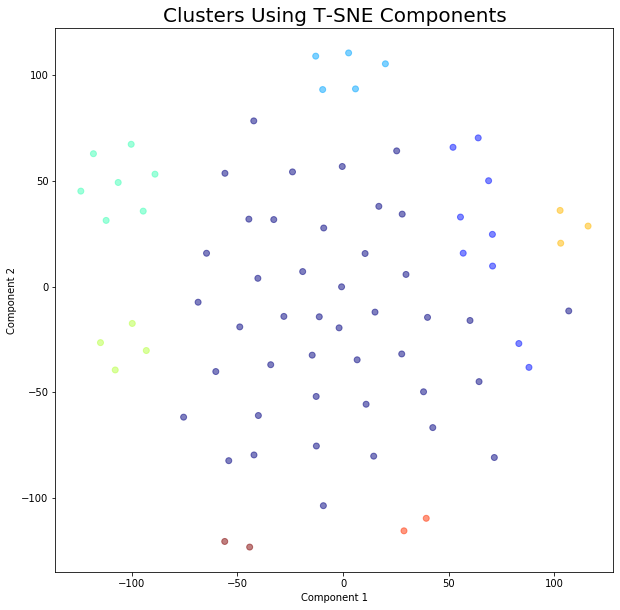

In [39]:
# Look at clusters
from sklearn.manifold import TSNE
tsne = TSNE()
g = pd.DataFrame(tsne.fit_transform(comps), columns=['one', 'two'])
g['cluster_no'] = cltr.labels_
import matplotlib.cm as cm
plt.figure(figsize=(10,10))
plt.title('Clusters Using T-SNE Components', fontsize=20)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(g['one'], g['two'], c=g['cluster_no'], cmap=cm.jet, alpha=0.5)
plt.show()

In [40]:
# Assign X, y, and the train test split
X = comps
y = df['cluster_no']

In [42]:
# Test logistic regression
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

1.0

In [43]:
# Fit logistic regression to entire data
lr.fit(X, y)

LogisticRegression(C=10, max_iter=1000, multi_class='multinomial', solver='sag')

In [44]:
# Assign cluster number to each job title in comps to pull particular cluster out for comparison
comps['cluster_no'] = y.values
comps.set_index('cluster_no', inplace=True)

In [45]:
from pyresparser import ResumeParser

In [46]:
data = ResumeParser('ASH1825022M-Rahat Uddin Azad.pdf').get_extracted_data()

In [49]:
resume=(','.join(word for word in data['skills']))

In [148]:
def give_suggestions(resume_text):
    # Vectorize user's skills and job descriptions
#     desc = pd.DataFrame(vec.transform([resume_text]).todense())
#     desc.columns = vec.get_feature_names()
    skillz = pd.DataFrame(vec2.transform([resume_text]).todense())
    skillz.columns = vec2.get_feature_names()
#     mat = pd.concat([skillz, desc], axis=1)

    # Tranform feature matrix with pca
    user_comps = pd.DataFrame(pca.transform(skillz))

    # Predict cluster for user and print cluster number
    cluster = lr.predict(user_comps)[0]
    print ('CLUSTER NUMBER', cluster, '\n\n')

    # Calculate cosine similarity
    cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==cluster]))

    # Get job titles from sample2 to associate cosine similarity scores with jobs
    samp_for_cluster = df[df['cluster_no']==cluster]
    cos_sim = cos_sim.T.set_index(samp_for_cluster.position)
    cos_sim.columns = ['score']

    # Print the top ten suggested jobs for the user's cluster
    print ('Top ten suggested for your cluster', '\n', cos_sim.sort_values('score', ascending=False)[:10], '\n\n')

    # Print the top five suggested jobs for each cluster
    skillz = skillz.T
    for i in range(8):
        cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==i]))
        samp_for_cluster = df[df['cluster_no']==i]
        cos_sim = cos_sim.T.set_index(samp_for_cluster.position)
        cos_sim.columns = ['score']
        top_5 = cos_sim.sort_values('score', ascending=False)[:5]

        # Merge top_5 with sample2 to get skills and description
        merged_top_5 = top_5.merge(df.set_index(df.position), how='left', left_index=True, right_index=True)
        print ('---------Top five suggested in cluster', i,  '---------\n', top_5, '\n\n')
        # Vectorize to find skills needed for each job title

        for job in merged_top_5.index:
            print("job  "+job)
            if merged_top_5.loc[job,'skill']=='':
                               continue
            job_skills = pd.DataFrame(vec2.transform([merged_top_5.loc[job,'skill']]).todense())
            job_skills.columns = vec2.get_feature_names()
            job_skills = job_skills.T
            job_skills.columns = ['score']
            job_skills = job_skills[job_skills['score'] != 0].sort_values('score', ascending=False)
            skillz.columns = ['score']
            skillz = skillz[skillz['score'] != 0]
            needed_skills = []
            scorey = []
            print(skillz.index)
            for i in job_skills.index:
                if i not in skillz.index:    
                    needed_skills.append(i)
                    scorey.append(job_skills.loc[i][0])
            top_skills = pd.DataFrame(zip(needed_skills, scorey), columns=['Skill', 'Importance'])
            print ('To become a/an '+ job+', \n these are the top ten skills you need:\n')
            print (top_skills[:10], '\n')

In [149]:
give_suggestions(resume)

CLUSTER NUMBER 0 


Top ten suggested for your cluster 
                                                        score
position                                                    
Full Stack Web Developer                            0.567688
Senior Web Developer - .Net/C#                      0.355186
None                                                0.355186
Web Developer                                       0.328478
Java Web Service Developer with Security Clearance  0.251913
Web Developer with PHP/TS/JS stack exp.             0.194639
Lead Developer for Mobile App, Web App, and API...  0.187070
Python and Web/Visualization Developer - Hybrid     0.181635
Intern-Web Developer                                0.131270
Web Developer                                       0.118893 


---------Top five suggested in cluster 0 ---------
                                                        score
position                                                    
Full Stack Web Developer          

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().